In this notebook, we're going to implement an MLP to predict the next character in the sequence. This modelling approach follows the paper [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). This isn't the first work that proposed the use of neural networks for word (!) level language modelling, but it was nevertheless a very influential paper. It's often cited to refer to this idea.
- Each of the 17000 words is embedded into an, e.g., 30-dimensional feature space. So we have 17000 points in a 30-dimensional space.
- In the beginning, the embeddings are initialized randomly. Then we tune the embeddings using backpropagation. Words that have a very similar meaning (or synonyms) will usually end up being very close in this space. Very different things will usually be far away in the embedding space.
- To train the neural network, we can maximize the log-likelihood of the training data under our model. This is exactly what we did previously.

Example:
- Consider the sentence fragment "A dog was running in a". Suppose that it wasn't a part of the training data, and we only encounter it in deployment. However, the dataset might contain very similar phrases, like "The dog was running in a". If the network learned that "a" and "the" are very similar, it put them very close in the embedding space. We can exploit this to be able to correctly predict the next word in the deployment example, even though we have never seen it before. This sample is therefore not actually OOD, as we have seen very similar examples. We *transfer knowledge through the embedding*, and so generalize better.
- The look-up table $C$ in the paper is a $17000 \times 30$ matrix. This is shared over words, and we optimize it during training. The second layer of the network contains $3 \times 30 = 90$ neurons. In the hidden layer, all neurons are fully connected to the previous 90 neurons. The output layer has 17000 neurons, all of which are fully connected to the hidden neurons. The outputs are 17000 logits. We apply the softmax function to get a valid probability distribution $p(\text{next word} \mid \text{previous words})$. We want to maximize the likelihood of the true next work in the dataset, given the previous words in the dataset.


In [1]:
import torch
import torch.nn.functional as F
from torch import Tensor
import matplotlib.pyplot as plt
from karpathy_nn.makemore.data.load_data import load_names
from karpathy_nn.micrograd.utils import apply_random_seed
import random


In [ ]:
apply_random_seed(42)

In [2]:
words = load_names()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)


32033

In [4]:
# Build the vocabuilary of tokens and mappings to/from integers
characters = sorted(list(set("".join(words))))
string_to_integer = {string: integer + 1 for integer, string in enumerate(characters)}
string_to_integer["."] = 0
integer_to_string = {integer: string for string, integer in string_to_integer.items()}
print(integer_to_string)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Create the dataset
block_size = (
    3  # Context length: how many characters do we take to predict the next one?
)
X, Y = [], []
for word in words[:5]:
    print(word)
    context = [0] * block_size
    for character in word + ".":
        idx = string_to_integer[character]
        X.append(context)
        Y.append(idx)

        print(
            "".join(integer_to_string[i] for i in context),
            "--->",
            integer_to_string[idx],
        )

        context = context[1:] + [idx]  # Crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype


(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

From the five words, we have created a dataset of 32 samples. Each input to the neural net is three integers, and we also have a label that is also an integer.

In [7]:
X


tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [8]:
Y


tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [9]:
C = torch.randn(27, 2)
C


tensor([[ 0.3398,  0.6858],
        [ 0.1480, -0.3134],
        [-0.6270, -0.9299],
        [-0.6622,  0.6997],
        [-1.4983,  0.6663],
        [ 0.6198, -0.7637],
        [ 0.0102, -2.0646],
        [-0.7267, -0.0279],
        [ 0.5047, -1.3677],
        [-0.8804, -0.1790],
        [ 1.6936, -0.1093],
        [ 0.0030,  0.1864],
        [-1.2437,  0.6344],
        [ 1.1227,  2.2106],
        [-0.9022,  0.5803],
        [ 0.9917,  0.0331],
        [ 0.4016, -0.8094],
        [ 0.3880, -0.4660],
        [-0.8894,  0.2483],
        [ 0.3130, -0.6143],
        [-1.3125, -0.8157],
        [-0.3948,  1.4741],
        [ 1.8541,  1.4140],
        [-0.7321, -1.2655],
        [ 0.1353, -2.1952],
        [ 0.4138,  0.5221],
        [ 1.7441, -0.2574]])

In [10]:
F.one_hot(
    torch.tensor(5), num_classes=len(integer_to_string)
).float() @ C  # First layer of our MLP


tensor([ 0.6198, -0.7637])

In [11]:
C[5]


tensor([ 0.6198, -0.7637])

In [12]:
C[X].shape


torch.Size([32, 3, 2])

In [13]:
C[X][13, 2]


tensor([ 0.1480, -0.3134])

In [14]:
X[13, 2]


tensor(1)

In [15]:
C[1]


tensor([ 0.1480, -0.3134])

In [16]:
emb = C[X]
emb.shape


torch.Size([32, 3, 2])

In [17]:
W1 = torch.randn(6, 100)
b1 = torch.randn(100)

print(emb.flatten(start_dim=1) @ W1 + b1)
# Creates a new tensor, very inefficient (there is no way to concatenate
# tensors just by manipulating the view attributes)
print(torch.cat(torch.unbind(emb, dim=1), dim=1) @ W1 + b1)
print(emb.view(-1, 6) @ W1 + b1)


tensor([[-1.7304, -2.7130,  0.1615,  ..., -0.6084,  1.4205, -1.8027],
        [-1.5892, -1.6765, -0.1116,  ..., -2.1646, -0.0938, -1.3554],
        [ 0.9889, -3.2672,  1.0578,  ...,  4.3039,  0.9977, -5.0346],
        ...,
        [-0.0108, -0.4739, -0.3908,  ..., -1.1756, -1.0889, -2.0041],
        [-1.1517,  0.1845, -1.0980,  ...,  0.1680,  1.0027, -0.8978],
        [-1.3889, -0.8312,  0.5669,  ...,  0.0074, -0.1572,  0.1354]])
tensor([[-1.7304, -2.7130,  0.1615,  ..., -0.6084,  1.4205, -1.8027],
        [-1.5892, -1.6765, -0.1116,  ..., -2.1646, -0.0938, -1.3554],
        [ 0.9889, -3.2672,  1.0578,  ...,  4.3039,  0.9977, -5.0346],
        ...,
        [-0.0108, -0.4739, -0.3908,  ..., -1.1756, -1.0889, -2.0041],
        [-1.1517,  0.1845, -1.0980,  ...,  0.1680,  1.0027, -0.8978],
        [-1.3889, -0.8312,  0.5669,  ...,  0.0074, -0.1572,  0.1354]])
tensor([[-1.7304, -2.7130,  0.1615,  ..., -0.6084,  1.4205, -1.8027],
        [-1.5892, -1.6765, -0.1116,  ..., -2.1646, -0.0938, -1

In [18]:
a = torch.arange(18)
a


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [19]:
a.shape


torch.Size([18])

In [20]:
a.view(2, 9)


tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [21]:
a.storage()  # Always a 1D vector
# .view() just changes how the storage is interpreted as a tensor.
# No memory is being copied.


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [22]:
h = torch.tanh(emb.flatten(start_dim=1) @ W1 + b1)
h


tensor([[-0.9391, -0.9912,  0.1601,  ..., -0.5430,  0.8897, -0.9471],
        [-0.9200, -0.9324, -0.1111,  ..., -0.9740, -0.0935, -0.8753],
        [ 0.7569, -0.9971,  0.7848,  ...,  0.9996,  0.7606, -0.9999],
        ...,
        [-0.0108, -0.4414, -0.3721,  ..., -0.8261, -0.7965, -0.9643],
        [-0.8183,  0.1824, -0.7998,  ...,  0.1664,  0.7627, -0.7152],
        [-0.8829, -0.6811,  0.5131,  ...,  0.0074, -0.1560,  0.1346]])

In [23]:
# Final layer
W2 = torch.randn(100, len(integer_to_string))
b2 = torch.randn(len(integer_to_string))

logits = h @ W2 + b2
logits.shape


torch.Size([32, 27])

In [24]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdims=True)
prob.shape


torch.Size([32, 27])

In [25]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss


tensor(13.3340)

In [26]:
# Single cell that contains everything
g = torch.Generator().manual_seed(2147483647)  # For reproducibility
C = torch.randn(len(integer_to_string), 2, generator=g, requires_grad=True)
W1 = torch.randn(6, 100, generator=g, requires_grad=True)
b1 = torch.randn(100, generator=g, requires_grad=True)
W2 = torch.randn(100, len(integer_to_string), generator=g, requires_grad=True)
b2 = torch.randn(len(integer_to_string), generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

# Number of parameters in total
print(sum(param.nelement() for param in parameters))

emb = C[X]  # (batch_size, 3, 2) -- embedded context for each sample
h = torch.tanh(emb.flatten(start_dim=1) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, len(integer_to_string))
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss


3481


tensor(17.7697, grad_fn=<NegBackward0>)

In [27]:
F.cross_entropy(logits, Y)


tensor(17.7697, grad_fn=<NllLossBackward0>)

``F.cross_entropy`` is much more efficient (no intermediate tensors) and much more numerically stable (maximum subtracted).
- PyTorch clusters up all of these operations and has fused kernels that very efficiently evaluates the expression. (Forward prop efficient)
- PyTorch also doesn't backpropagate through these individual steps: there is a simple form for the gradient of the entire cross-entropy function that can be used directly. (Backward prop efficient)

In [28]:
def forward(X: Tensor, Y: Tensor, parameters: list[Tensor]) -> Tensor:
    C, W1, b1, W2, b2 = parameters
    emb = C[X]
    h = torch.tanh(emb.flatten(start_dim=1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    return loss


def train(
    num_steps: int,
    learning_rate: float,
    X: Tensor,
    Y: Tensor,
    parameters: list[Tensor],
    verbose: bool = True,
) -> None:
    for step in range(num_steps):
        loss = forward(X, Y, parameters)

        if verbose:
            print(f"Step {step}: loss = {loss.item()}")

        for param in parameters:
            param.grad = None

        loss.backward()

        # Backward pass
        for param in parameters:
            param.data -= learning_rate * param.grad

    if not verbose:
        print(f"Final loss = {loss.item()}")


train(num_steps=1000, learning_rate=0.1, X=X, Y=Y, parameters=parameters, verbose=False)


Final loss = 0.2561368942260742


Note that we are only overfitting 32 samples. It is very easy to make the neural network fit to this single batch.

Why can't we achieve 0 loss? Because we have mixed supervision in our dataset:
- ... -> e
- ... -> o
- ... -> a
- ... -> s

For inputs without mixed supervision, we recover the exact correct output.

In [29]:
def create_dataset(
    words: list[str], string_to_integer: dict[str, int], block_size: int = 3
) -> tuple[Tensor, Tensor]:
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        for character in word + ".":
            idx = string_to_integer[character]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


def initialize_parameters(num_tokens: int) -> list[Tensor]:
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn(num_tokens, 2, generator=g, requires_grad=True)
    W1 = torch.randn(6, 100, generator=g, requires_grad=True)
    b1 = torch.randn(100, generator=g, requires_grad=True)
    W2 = torch.randn(100, num_tokens, generator=g, requires_grad=True)
    b2 = torch.randn(num_tokens, generator=g, requires_grad=True)

    return [C, W1, b1, W2, b2]


In [30]:
X, Y = create_dataset(words, string_to_integer)
parameters = initialize_parameters(num_tokens=len(string_to_integer))
train(num_steps=20, learning_rate=0.1, X=X, Y=Y, parameters=parameters)


Step 0: loss = 19.505229949951172
Step 1: loss = 17.08449363708496
Step 2: loss = 15.776531219482422
Step 3: loss = 14.83333683013916
Step 4: loss = 14.002594947814941
Step 5: loss = 13.253252029418945
Step 6: loss = 12.579911231994629
Step 7: loss = 11.9830961227417
Step 8: loss = 11.470490455627441
Step 9: loss = 11.051854133605957
Step 10: loss = 10.709585189819336
Step 11: loss = 10.407631874084473
Step 12: loss = 10.127808570861816
Step 13: loss = 9.864364624023438
Step 14: loss = 9.61450481414795
Step 15: loss = 9.376440048217773
Step 16: loss = 9.148946762084961
Step 17: loss = 8.931111335754395
Step 18: loss = 8.722232818603516
Step 19: loss = 8.521750450134277


Let's break up our dataset into mini-batches.

In [31]:
def forward(
    X: Tensor, Y: Tensor, parameters: list[Tensor], batch_size: int = 512
) -> Tensor:
    C, W1, b1, W2, b2 = parameters

    if batch_size == len(X):
        X_batch = X
        Y_batch = Y
    else:
        indices = torch.randint(0, X.shape[0], (batch_size,))
        X_batch = X[indices]
        Y_batch = Y[indices]
    emb = C[X_batch]
    h = torch.tanh(emb.flatten(start_dim=1) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_batch)

    return loss


In [32]:
X, Y = create_dataset(words, string_to_integer)
parameters = initialize_parameters(num_tokens=len(string_to_integer))
train(num_steps=1000, learning_rate=0.1, X=X, Y=Y, parameters=parameters, verbose=False)


Final loss = 2.655564785003662


As we are dealing with mini-batches, the quality of our gradient is lower. These are not the gradients over the entire dataset, only a small subset of it. But it is good enough to be useful, and it makes training very fast. It is much better to have an approximate gradient and make many steps than it is to evaluate the exact gradient and take fewer steps. Matter of fact, the noise stochastic gradient descent introduces can help in achieving better test accuracy.

### Searching for a good learning rate

In [33]:
lrs = torch.linspace(-3, 0, 1000)
lrs = 10**lrs
lrs


tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [34]:
lrs = torch.logspace(-3, 0, 1000)
lrs


tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [35]:
parameters = initialize_parameters(num_tokens=len(string_to_integer))
C, W1, b1, W2, b2 = parameters

lri = []
lossi = []

for i in range(1000):
    idx = torch.randint(0, X.shape[0], (32,))

    emb = C[X[idx]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[idx])
    print(loss.item())

    for param in parameters:
        param.grad = None
    loss.backward()

    lr = lrs[i]

    for param in parameters:
        param.data -= lr * param.grad

    # Track stats
    lri.append(lr)
    lossi.append(loss.item())


17.732702255249023
20.39100456237793
22.212892532348633
18.168304443359375
20.32712173461914
17.5830135345459
19.330341339111328
19.388395309448242
20.28860092163086
18.201444625854492
19.17503547668457
20.564476013183594
20.43487548828125
21.17230796813965
20.615503311157227
16.429044723510742
16.609027862548828
20.133283615112305
17.8748779296875
19.95508575439453
19.803279876708984
19.71059799194336
17.589736938476562
19.43290901184082
21.874675750732422
20.45779037475586
20.98611831665039
19.025163650512695
17.403331756591797
18.158124923706055
18.714292526245117
16.56267547607422
19.134443283081055
13.251580238342285
22.184017181396484
15.918084144592285
18.306089401245117
22.428050994873047
16.513673782348633
21.244888305664062
15.845444679260254
18.71114158630371
17.08005714416504
16.25472640991211
19.863779067993164
18.442691802978516
19.1829776763916
18.874422073364258
16.894176483154297
17.677274703979492
17.657405853271484
18.603107452392578
14.887605667114258
17.48338317871

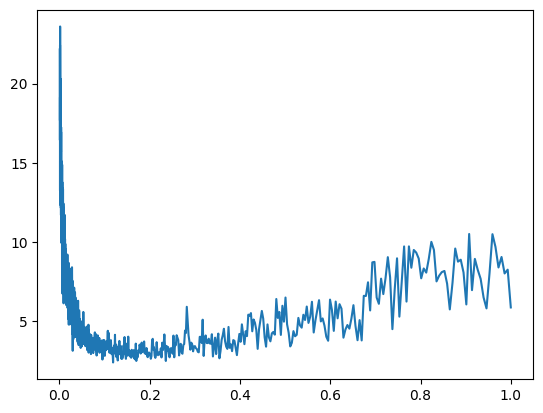

In [36]:
plt.plot(lri, lossi)


0.15 seems to be a good candidate. With a single LR, it's a good idea to choose it a little lower such that we can squeeze out performance at later epochs.

In [37]:
X, Y = create_dataset(words, string_to_integer)
parameters = initialize_parameters(num_tokens=len(string_to_integer))
train(
    num_steps=20000, learning_rate=0.1, X=X, Y=Y, parameters=parameters, verbose=False
)

# We see different results if we keep rerunning the cell, as the mini-batch sampling was
# not seeded.


Final loss = 2.36897349357605


Let's actually add a proper LR scheduler.

In [38]:
class Scheduler:
    def __init__(
        self, initial_lr: float, decay_steps: list[int], decay_factor: float = 0.1
    ) -> None:
        self._decay_steps = decay_steps
        self._decay_factor = decay_factor
        self._counter = -1
        self._lr = initial_lr

    def step(self) -> float:
        self._counter += 1

        if self._counter in self._decay_steps:
            self._lr *= self._decay_factor

        return self._lr


def train(
    num_steps: int,
    X: Tensor,
    Y: Tensor,
    parameters: list[Tensor],
    scheduler: Scheduler,
    verbose: bool = True,
) -> None:
    for step in range(num_steps):
        learning_rate = scheduler.step()
        loss = forward(X, Y, parameters)

        if verbose:
            print(f"Step {step}: loss = {loss.item()}")

        for param in parameters:
            param.grad = None

        loss.backward()

        # Backward pass
        for param in parameters:
            param.data -= learning_rate * param.grad

    if not verbose:
        print(f"Final loss = {loss.item()}")


In [39]:
X, Y = create_dataset(words, string_to_integer)
parameters = initialize_parameters(num_tokens=len(string_to_integer))
scheduler = Scheduler(initial_lr=1, decay_steps=[5, 18000])
train(
    num_steps=20000, X=X, Y=Y, parameters=parameters, scheduler=scheduler, verbose=False
)


Final loss = 2.384399652481079


After running the above cell multiple times, we can see that it's not always better than training with a fixed LR. The performance generally fluctuates. Still, the bigram model in the last notebook achieved 2.45, and we usually get a better loss than that here. Still, we cannot say that our model is better than the bigram model based on this information, because we can only see the training loss. It might very well happen that the model severely overfits to the training set (~memorizes it verbatim), and that's why it achieves a better loss. We need to check how well the learned rules of the model *generalize*.

Let's create a train/dev (validation)/test split. We should only evavaluate our model on the test set very sparingly and very few times. This is because every single time we evaluate our model on the test set we learn something from it. I.e., we start overfitting to the test set characteristics as well.

In [40]:
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = create_dataset(words=words[:n1], string_to_integer=string_to_integer)
Xdev, Ydev = create_dataset(words=words[n1:n2], string_to_integer=string_to_integer)
Xte, Yte = create_dataset(words=words[n2:], string_to_integer=string_to_integer)


In [41]:
def train(
    num_steps: int,
    Xtr: Tensor,
    Ytr: Tensor,
    Xdev: Tensor,
    Ydev: Tensor,
    parameters: list[Tensor],
    scheduler: Scheduler,
    val_freq: int = 1000,
    batch_size: int = 512,
) -> None:
    for step in range(num_steps):
        learning_rate = scheduler.step()
        loss = forward(Xtr, Ytr, parameters, batch_size=batch_size)

        if step % val_freq == 0:
            with torch.no_grad():
                val_loss = forward(Xdev, Ydev, parameters, batch_size=len(Xdev)).item()
            print(
                f"Step {step}: training loss = {loss.item()}, validation loss = {val_loss}"
            )

        for param in parameters:
            param.grad = None

        loss.backward()

        # Backward pass
        for param in parameters:
            param.data -= learning_rate * param.grad

    loss = forward(Xtr, Ytr, parameters, batch_size=len(Xtr))
    with torch.no_grad():
        val_loss = forward(Xdev, Ydev, parameters, batch_size=len(Xdev)).item()
    print(f"Final training loss = {loss.item()}, validation loss = {val_loss}")


In [42]:
parameters = initialize_parameters(num_tokens=len(string_to_integer))
scheduler = Scheduler(initial_lr=1, decay_steps=[5, 18000, 50000])
train(
    num_steps=100000,
    Xtr=Xtr,
    Ytr=Ytr,
    Xdev=Xdev,
    Ydev=Ydev,
    parameters=parameters,
    scheduler=scheduler,
    val_freq=5000,
    batch_size=64,
)


Step 0: training loss = 19.007413864135742, validation loss = 19.446435928344727
Step 5000: training loss = 2.45619535446167, validation loss = 2.4714863300323486
Step 10000: training loss = 2.414703369140625, validation loss = 2.436706781387329
Step 15000: training loss = 2.1490132808685303, validation loss = 2.4215428829193115
Step 20000: training loss = 2.1514761447906494, validation loss = 2.357757091522217
Step 25000: training loss = 2.375187635421753, validation loss = 2.3561882972717285
Step 30000: training loss = 2.0933547019958496, validation loss = 2.354271650314331
Step 35000: training loss = 2.1225461959838867, validation loss = 2.3492422103881836
Step 40000: training loss = 2.374159812927246, validation loss = 2.3495259284973145
Step 45000: training loss = 2.5334131717681885, validation loss = 2.3474912643432617
Step 50000: training loss = 2.198753595352173, validation loss = 2.3458380699157715
Step 55000: training loss = 2.5449318885803223, validation loss = 2.34179401397

The training and dev loss are about equal, so we're not overfitting. This model is not powerful enough to purely memorize the dataset. Here we're actually underfitting, because the network is so small. We can fit the dataset better by scaling up our model, but we have to be careful to not overfit.

Note: If we use the entire dataset for each update, training becomes prohibitively slow. When using minbatches, the final loss fluctuates quite a bit, even if we choose a high batch size (e.g., 4096).

Let's scale up our model and see first how it behaves with a fixed learning rate.

In [43]:
def initialize_parameters(num_tokens: int) -> list[Tensor]:
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn(num_tokens, 2, generator=g, requires_grad=True)
    W1 = torch.randn(6, 500, generator=g, requires_grad=True)
    b1 = torch.randn(500, generator=g, requires_grad=True)
    W2 = torch.randn(500, num_tokens, generator=g, requires_grad=True)
    b2 = torch.randn(num_tokens, generator=g, requires_grad=True)

    return [C, W1, b1, W2, b2]


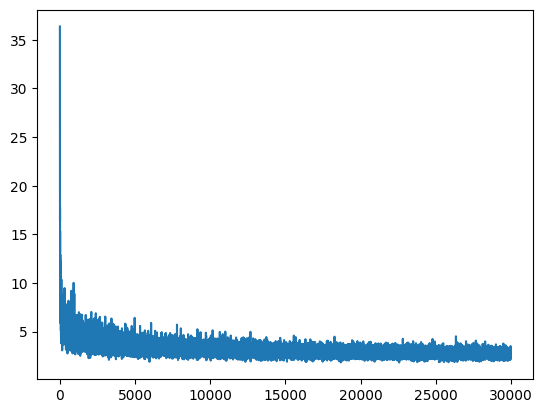

In [44]:
parameters = initialize_parameters(num_tokens=len(string_to_integer))
C, W1, b1, W2, b2 = parameters

lossi = []
stepi = list(range(30000))

for i in range(30000):
    idx = torch.randint(0, X.shape[0], (32,))

    emb = C[X[idx]]
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[idx])

    for param in parameters:
        param.grad = None
    loss.backward()

    lr = 0.1

    for param in parameters:
        param.data -= lr * param.grad

    # Track stats
    lossi.append(loss.item())

_ = plt.plot(stepi, lossi)


There's quite a bit of "thickness" to the plot. This is because we are optimizing over mini-batches, so the loss fluctuates quite a bit simply because of different mini-batches. As we also made the network bigger, it will generally need more steps.

In [45]:
parameters = initialize_parameters(num_tokens=len(string_to_integer))
scheduler = Scheduler(
    initial_lr=1, decay_steps=[5, 600, 18000, 50000], decay_factor=0.5
)
train(
    num_steps=100000,
    Xtr=Xtr,
    Ytr=Ytr,
    Xdev=Xdev,
    Ydev=Ydev,
    parameters=parameters,
    scheduler=scheduler,
    val_freq=5000,
    batch_size=64,
)


Step 0: training loss = 38.79114532470703, validation loss = 35.912689208984375
Step 5000: training loss = 3.3986098766326904, validation loss = 3.1375415325164795
Step 10000: training loss = 2.751959800720215, validation loss = 2.7457165718078613
Step 15000: training loss = 2.4897124767303467, validation loss = 2.821732759475708
Step 20000: training loss = 2.2685723304748535, validation loss = 2.426490068435669
Step 25000: training loss = 2.2788336277008057, validation loss = 2.397268533706665
Step 30000: training loss = 2.317457914352417, validation loss = 2.398296356201172
Step 35000: training loss = 2.408932685852051, validation loss = 2.382577896118164
Step 40000: training loss = 2.4099040031433105, validation loss = 2.373685836791992
Step 45000: training loss = 2.2173573970794678, validation loss = 2.3585045337677
Step 50000: training loss = 2.2197988033294678, validation loss = 2.360724925994873
Step 55000: training loss = 2.1227633953094482, validation loss = 2.296186923980713


There's not *so* much improvement, even after tweaking the rates a bit. It could be that the bottleneck of the model is the 2-dimensional embedding layer. Let's make that bigger too. But before we do that, let's visualize the character embeddings our model learned.

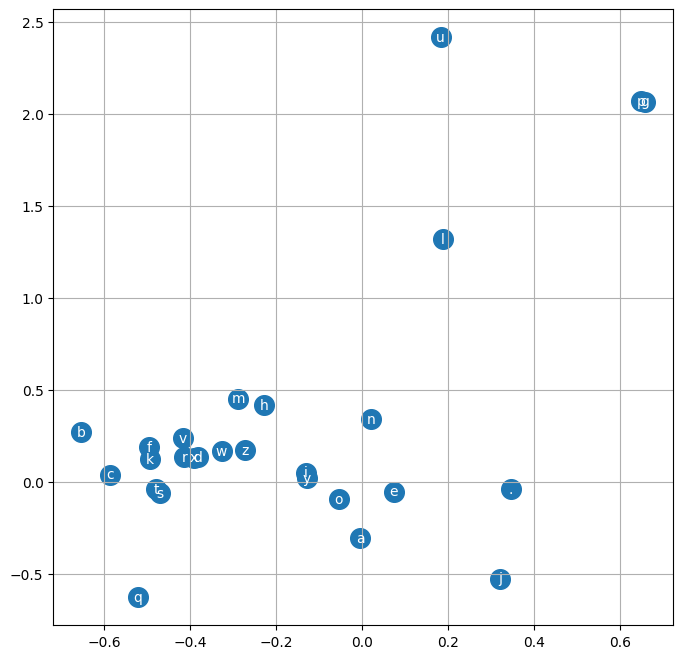

In [46]:
plt.figure(figsize=(8, 8))
plt.grid("minor")
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        integer_to_string[i],
        ha="center",
        va="center",
        color="white",
    )


Seemingly, the network managed to cluster the vowels closer. It believes that these tokens are quite similar. p and g have special embedding vectors that stand out. There is a little bit of structure here and this is definitely not random.

By scaling up the embedding size, we lose the ability to visualize them. However, we expect the larger embeddings to capture the character's semantic meaning much better, thereby resolving the current bottleneck.

In [64]:
def initialize_parameters(num_tokens: int) -> list[Tensor]:
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn(num_tokens, 50, generator=g, requires_grad=True)
    W1 = torch.randn(150, 150, generator=g, requires_grad=True)
    b1 = torch.randn(150, generator=g, requires_grad=True)
    W2 = torch.randn(150, num_tokens, generator=g, requires_grad=True)
    b2 = torch.randn(num_tokens, generator=g, requires_grad=True)

    return [C, W1, b1, W2, b2]


parameters = initialize_parameters(num_tokens=len(string_to_integer))
scheduler = Scheduler(initial_lr=0.1, decay_steps=[100000], decay_factor=0.1)
train(
    num_steps=200000,
    Xtr=Xtr,
    Ytr=Ytr,
    Xdev=Xdev,
    Ydev=Ydev,
    parameters=parameters,
    scheduler=scheduler,
    val_freq=5000,
    batch_size=32,
)


Step 0: training loss = 22.98038101196289, validation loss = 22.816099166870117
Step 5000: training loss = 3.4159483909606934, validation loss = 2.763704776763916
Step 10000: training loss = 2.5071725845336914, validation loss = 2.4731125831604004
Step 15000: training loss = 2.2573249340057373, validation loss = 2.423353910446167
Step 20000: training loss = 2.6320953369140625, validation loss = 2.366960048675537
Step 25000: training loss = 2.016991138458252, validation loss = 2.345845937728882
Step 30000: training loss = 2.246249198913574, validation loss = 2.304871082305908
Step 35000: training loss = 2.1622166633605957, validation loss = 2.281041383743286
Step 40000: training loss = 1.97430419921875, validation loss = 2.2995946407318115
Step 45000: training loss = 1.9738420248031616, validation loss = 2.2797701358795166
Step 50000: training loss = 2.495920181274414, validation loss = 2.2713499069213867
Step 55000: training loss = 2.077303171157837, validation loss = 2.287130355834961

This looks notably better than before, so it *is* the case that the embedding size was holding us back. But now we can see that the training and validation performance start to slowly depart. The number of parameters might be large enough that we slowly start to overfit.

In practice, we run lots of experiments and we choose which hyperparameter setting gives us the best final dev performance. Once we find that, we evaluate our model on the test set **once**. That's the nubmer we report in our paper.

There are many ways to go from here. We can keep tuning the optimization hyperparameters, we can play with the neural network architecture (increase the number of neurons in the hidden layer, in the embedding, etc.), or we can play with the context size as well. These could all further improve the loss.

Note: If we just increase both the embedding size and the hidden layer size without thinking (e.g. embedding size 50, hidden size 500), we are likely to see quite severe overfitting. In this case, actually *decreasing* the hidden size and increasing the embedding size until a certain threshold seems to work best.

Increasing the length of the context would also decrease the loss further.

In [67]:
def sample(parameters: list[Tensor], num_samples: int) -> list[str]:
    C, W1, b1, W2, b2 = parameters
    g = torch.Generator().manual_seed(2147483657)

    out_list = []

    for _ in range(num_samples):
        gen_list = []
        context = [0] * block_size
        while True:
            emb = C[context]  # (block_size, d)
            h = torch.tanh(emb.view(1, -1) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            idx = torch.multinomial(probs, num_samples=1, generator=g).item()
            context = context[1:] + [idx]

            if idx == 0:
                break

            gen_list.append(idx)
        out_list.append("".join(integer_to_string[integer] for integer in gen_list))

    return out_list


sample(parameters=parameters, num_samples=10)


['carmahzati',
 'hari',
 'kim',
 'shreet',
 'khalessa',
 'jazhuel',
 'deliah',
 'jareen',
 'nellara',
 'chriha']

Exercise: The notebook was not careful with the initialization of the network.

(a) What is the loss you woudl expect if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve?

$$p(\text{GT class} \mid X) = \frac{1}{27} \implies -\log p(\text{GT class} \mid X) = \log 27 \approx 3.2958$$

In [69]:
parameters = initialize_parameters(num_tokens=len(string_to_integer))
with torch.no_grad():
    val_loss = forward(Xdev, Ydev, parameters, batch_size=len(Xdev)).item()
val_loss


22.816099166870117

(b) Can you tune the initialization to get a starting loss that is much more similar to the one in (a)?

In [104]:
def initialize_parameters2(num_tokens: int) -> list[Tensor]:
    g = torch.Generator().manual_seed(2147483647)
    C = torch.randn(num_tokens, 50, generator=g, requires_grad=True)
    W1 = torch.randn(150, 150, generator=g, requires_grad=True)
    b1 = torch.zeros(150, requires_grad=True)  # Set biases to zero
    W2 = torch.randn(150, num_tokens, generator=g, requires_grad=True)
    b2 = torch.zeros(num_tokens, requires_grad=True)

    return [C, W1, b1, W2, b2]


def initialize_parameters3(num_tokens: int) -> list[Tensor]:
    """Xavier / Glorot initialization."""
    g = torch.Generator().manual_seed(2147483647)
    C = (
        torch.randn(num_tokens, 50, generator=g, requires_grad=True)
        * (2 / (num_tokens + 50)) ** 0.5
    )
    W1 = (
        torch.randn(150, 150, generator=g, requires_grad=True)
        * (2 / (150 + 150)) ** 0.5
    )
    b1 = torch.zeros(150, requires_grad=True)
    W2 = (
        torch.randn(150, num_tokens, generator=g, requires_grad=True)
        * (2 / (150 + num_tokens)) ** 0.5
    )
    b2 = torch.zeros(num_tokens, requires_grad=True)

    return [C, W1, b1, W2, b2]


In [105]:
parameters = initialize_parameters2(num_tokens=len(string_to_integer))
with torch.no_grad():
    val_loss = forward(Xdev, Ydev, parameters, batch_size=len(Xdev)).item()
val_loss


24.790441513061523

In [106]:
parameters = initialize_parameters3(num_tokens=len(string_to_integer))
with torch.no_grad():
    val_loss = forward(Xdev, Ydev, parameters, batch_size=len(Xdev)).item()
val_loss


3.31752872467041

This is nearly exactly a uniform random prediction's loss.